# Introduction

In this exercise we will:

1. Implement K-means clustering and use it to compress an image.  We'll start with a simple 2D data set to see how K-means works, then we'll apply it to image compression.  


2. Experiment with principal component analysis and see how it can be used to find a low-dimensional representation of images of faces.

# Part 1 - K-means Clustering
-----------

# Setting the Scene

To start out we're going to implement and apply K-means to a simple 2-dimensional data set to gain some intuition about how it works.  

Recall that K-means is an iterative, unsupervised clustering algorithm that groups similar instances together into clusters.  

# K-means Algorithm

Recall the K-means algorithm is as follows:

1. <b>Inputs:</b>

    (a) The number of desired clusters, $K$; and
    
    (b) The unlabelled training set, $\{x^1, x^2, ... x^m\}$
    
  The input vector will be $n$ dimensional, not $n+1$ dimensional, because we do not need to add a bias unit $x_0$ unlike with supervised techniques covered previously.
  

2. <b>Cluster Initialization Step:</b> randomly initialize $K$ cluster centroids, $\mu_1, \mu_2, ...\mu_K$.


3. <b>Cluster Assignment Step:</b> repeat for $i$ = 1 to $m$, i.e. for each example the below steps:

    (a) $min_k \| x^{(i)} - \mu_k\|^2$, i.e. find the value of $k$ (the specific cluster centroid) that is nearest to each sample.  The bit in $\|\|$ represents the <b>normal</b> or <b>norm</b>, which is simply the straight line distance between the training sample and the particular centroid $k$.
    
    (b) set the result from (a) as the value of $c^{(i)}$.


4. <b>Cluster Move Step:</b> for $k = 1$ to $K$ set $\mu_k :=$ average of points assigned to cluster $k$ afte step (3).  In other words, it updates each centroid's coorindates to the average coordinates from all training samples assigned to it in step 3.

    For example if after step (3) the $2^{nd}$ centroid, $\mu$ has assigned to it training samples $x^{(1)}, x^{(5)}, x^{(6)}$ and $x^{(10)}$ then the step (4) calculation is as follows:
    
\begin{align}
\mu_2 = \frac{1}{4}(x^{(1)} + x^{(5)} + x^{(6)} + x^{(10)})
\end{align}

5. <b>Note:</b> if after step (3) a centroid has no training samples assigned to it then we eliminate that centroid, resulting in $K-1$ clusters.

# Step 1 - Load the Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

# Step 2 - Load the Data

In [27]:
data = loadmat('ex7data2.mat')
X = data['X']

# Step 3 - Cluster Assignment

## (a) Recap

In the "Cluster Assignment" step of the K-means algorithm, the algorithm first assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids.

Specifically, for every example $i$ we set:

\begin{align}
c^{(i)}:= k \text{ that minimizes }\|x^{(i)} - \mu_k \|^2
\end{align}

Where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_k$ is the position (value) of the $k^{th}$ centroid.

The result of this step is to generate "clusters", i.e. the groups of samples assigned to each centroid

## (b) The Cluster Assignment Function

In [28]:
def find_closest_centroids(X, centroids):
    # Defines variable m = to no. of samples, i.e. 50
    m = X.shape[0]
    
    # Defines variable k = to no. of centroids, i.e. 16
    k = centroids.shape[0]
    
    # Defines variable idx = to 50 item 1d array of 0s.  Intended to store
    # the index of the centroid nearest each sample.  Equivalent to c^(i)
    idx = np.zeros(m)
    
    # Loops over each of the 50 samples, i.e. from index 0 to 49 of m
    for i in range(m):
        
        # 
        min_dist = 1000000
        
        # Loops over each of the 3 initial centroids
        for j in range(k):
            
            # Vectorised implementation. Calculates squared distance 
            # between each sample and each centroid, e.g. the distance
            # between sample 1 and centroid 1, sample 1 and centroid 2 and
            # so on.
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            
            # Checks whether distance between sample and current centroid
            # is less than the then current minimum distance.
            if dist < min_dist:
                
                # Updates min_dist variable with dist if distance between
                # sample and current centroid under comparison is less 
                # than the previous comparison.
                min_dist = dist
                
                # Updates idx with the index of the centroid currently
                # understood as the shortest distance from the sample
                idx[i] = j
    
    # Returns idx values describing which centroid is nearest each sample
    return idx

## (c) Testing the function

Let's test the function to make sure it's working as expected.  

We'll use the test case provided in the exercise, i.e. centroids at: [3, 3], [6, 2] and [8, 5].

In [29]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

array([ 0.,  2.,  1.])

The output matches the expected values in the text.

<b>Note:</b> remember our arrays are zero-indexed instead of one-indexed (as is the case in Matlab) so the values are one lower than in the exercise.  

# Step 4 - Cluster Move

## (a) Recap

After Step 3 we have generated clusters.  Next we need a function to compute the centroid of each cluster.  Recall that:

* The centroid is simply the mean of all of the examples currently assigned to the cluster.


* The centroid of each cluster will form the new centroid position used when re-running the Cluster Assignment step via the iterative process described above.


* Specifically, for every centroid $k$, we set:

\begin{align}
\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
\end{align}


* Where $C_k$ is the set of examples assigned to centroid $k$.  Concretely, if two examples, e.g. $x^{(3)}$ and $x^{(5)}$, are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)})$

## (b) Defining the Cluster Move Function

In [30]:
def compute_centroids(X, idx, k):
    
    # Creates new variables m and n, each equal to X.shape, i.e. 50
    # for this example.
    m, n = X.shape
    
    # Creates np array of k x n dimensions, i.e. 3 x 50 for this example.
    centroids = np.zeros((k, n))
    
    # Loop over every centroid
    for i in range(k):
        
        # Uses idx index to identify which samples are assigned to the 
        # current centroid
        indices = np.where(idx == i)
        
        # Updates each centroid with the mean of all examples currently assigned
        # to that cluster
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    # Returns updated centroids
    return centroids

In [31]:
compute_centroids(X, idx, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

This output also matches the expected values from the exercise.  So far so good.  

# Step (5) - Pulling it altogether

The next part involves actually running the algorithm for some number of iterations and visualizing the result.  

## (a) Defining a function to iterate K-means


This step was implemented for us in the exercise, but since it's not that complicated I'll build it here from scratch.  In order to run the algorithm we just need to alternate between assigning examples to the nearest cluster and re-computing the cluster centroids.

In [32]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

## (b) Running K-means

In [33]:
idx, centroids = run_k_means(X, initial_centroids, 10)

## (c) Plotting K-means clustering results after 10 iterations

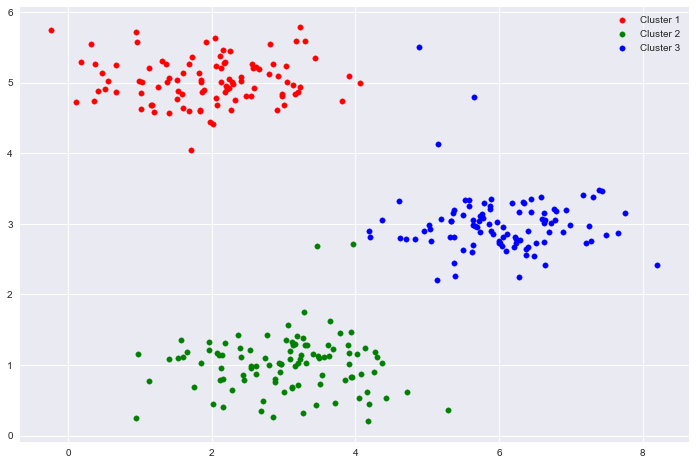

In [34]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()

# Step (6) - Running it on real data

## (a) Randomly initialize centroids

One step we skipped over is a process for initializing the centroids, i.e because in the above we tested using preset initial centroids rather than building a function to randomly initialise before running K-means.

Recall that:

* Without randomly initializing centroids this can affect the convergence of the algorithm.  


* Andrew Ng suggests the best way to randomly intialize centroids is to randomly select <b>$k$ training samples</b> as the initial centroids.

Let's build a function to do just that!

In [35]:
def init_centroids(X, k):
    
    # New variables m and n.  M = no. of samples; n = no. of features.
    m, n = X.shape
    
    # New centroids variable, of k x n dimensions
    centroids = np.zeros((k, n))
    
    # New idx variable where 0 = lowest value, m = highest value, k =
    # no. of random values.  I.e. generates 3 random numbers between 0 and
    # m in value
    idx = np.random.randint(0, m, k)
    
    # Loop over each initial centroid k
    for i in range(k):
        
        # Assign each centroid k a training sample at the index equal 
        # to the random numbers generated by idx = np.random.randint(0, m, k)
        centroids[i,:] = X[idx[i],:]
    
    return centroids

Running `init_centroids` to generate randomly intialized centroids:

In [36]:
init_centroids(X, 3)

array([[ 2.90401653,  4.61220411],
       [ 5.50295759,  2.62924634],
       [ 3.1189017 ,  0.69438336]])

## (b) Running K-means for image compression

Our next task is to apply K-means to image compression.  The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments.  

### (i) The image

Here's the image we're going to compress:

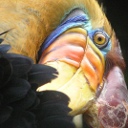

In [37]:
from IPython.display import Image
Image(filename='bird_small.png')

### (ii) The Data 

The raw pixel data has been pre-loaded for us so let's pull it in.  To explain the data:

* In a straightforward 24-bit colour representation of an image each pixel is represented as three 8-bit unsigned integers, i.e. positive integers, ranging from 0 to 255 that specify the red, green and blue intensity values.  This encoding is often referred to as RGB encoding.


* Our image contains 1,000s of colours, and in this part of the exericse we will reduce those colours to 16!


* By doing so we end up only having to store the RGB values of the 16 selected colours, and for each pixel in the image you now only need to store the index of the colour at that location (where only 4 bits are necessary to represent 16 possibilities).


In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. 


1. Concretely, you will: treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. 


2. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

### (iii) Load the Data

In [38]:
image_data = loadmat('bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ..., 
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ..., 
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ..., 
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ..., 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ..., 
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ..., 
         [ 80,  38,  40],
         [ 68,  39,  40],
 

### (iv) Understand the Data

In [39]:
A = image_data['A']
A[0][0]

array([219, 180, 103], dtype=uint8)

This creates a three-dimensional matrix A whose:

1. first two indices identify a pixel position; and 
   
   
2. last index represents red, green, or blue. 


For example:

* `A[0][0]`, per the above code snippet, provides the RGB values for the pixel at `0, 0` coordinates in the image.


* Those RGB values are: [219, 180, 103].


* Where red = 219, green = 180 and blue = 103.  


* Altogether, we can find the RGB values (e.g. `A[0][0]` finds RGB values for pixel at `0, 0`) or specific RGB value at any given pixel (e.g. `A[0][0][0]` finds red value for pixel at `0, 0`.  

### (vi) Reshape the Data

The code inside ex7.m first loads the image, and then reshapes it to create an m x 3 matrix of pixel colors (where m = 16384 = 128 x 128), and calls your K-means function on it. 

Now we need to apply some pre-processing to the data and feed it into the K-means algorithm.

In [40]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

### (v) Run K-means on the image data

In [41]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)

# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [42]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

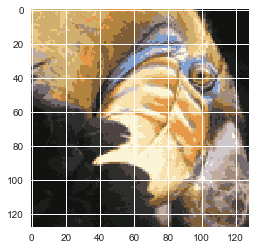

In [43]:
plt.imshow(X_recovered)

To recap:

* We've essentially found the top $K = 16$ colours to represent the image, 


* Assigned each pixel a new value depending on which colour cluster to which we found it belongs.


* The original image required 24 bits for each one of the 128 x 128 pixel locations, resulting in a total size of 393,216 bits.


* The new representation requires requires some overhead storage in the form of a dictionary of 16 colours, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location.  This means the final number of bits for the reduced image is only 16 x 24 + 128 x 128 x 4 = 65,920 bits.


* All in all we've compressed the original image by a factor of 6!

# Part 2 - Principal component analysis
--------------

# Setting the Scene

PCA is a linear transformation that finds the <b>"principal components"</b>, or directions of greatest variance, in a data set.  

It can be used for dimension reduction among other things.  

In this exercise we're tasked with:

1. Implementing PCA and applying it to a simple 2-dimensional data set to see how it works; and


2. Applying PCA to a bigger dataset of 5,000 face image dataset.

# The PCA algorithm

## Pre-processing

1. <b>Mean Normalization:</b> compute the mean of each feature $x_j^{(i)}$ and replace each feature $x_j^{(i)}$ with $x_j - \mu_j$.  Therefore, each feature now has zero mean.


2. <b>Feature Scaling:</b> scale each feature to have a comparable range of values, i.e. $x_j^{(i)} \leftarrow \frac{x_j^{(i)} - \mu_j}{s_j}$, where $s_j$ is the range of values, e.g. the max - min values or standard deviation.

## Computation

3. <b>Covariance Matrix:</b> compute using this formula: $\Sigma = \frac{1}{m}\sum_{i = 1}^{n}(x^{(i)})(x^{(i)})^T$ where:

    (a) $m$ is number of samples.
    
    (b) $n$ is number of original dimensions.
    
    (c) $k$ is number of desired dimensions.
    
    (d) $x^{(i)}$ is an $n$ x $1$ vector.
    
    (e) $X$ is a $m$ x $n$ matrix (row-wise stored examples).  
    
    (f) The product of $x^{(i)}$ and $x^{(i)}$ will be an $n$ x $n$ matrix, which are the dimensions of $\Sigma$.
  
   
   
4. <b>Eigen Vectors:</b> compute Eigen Vectors of the matrix $\Sigma$ using a <b>Singular Value Decomposition</b> ("<b>SVD</b>") function, which returns three matrices, $U$, $S$ and $V$. We use only the $U$ matrix which:

    (a) is also $n$ x $n$; and
    
    (b) has its columns being exactly the vectors $u^{(1)},...u^{(2)}, u^{(n)}$ that we want in order to plot a 1D+ surface onto which to project the original data.


5. Take the desired $k$ number of Eigen Vectors from Step (4), i.e. $u^{(1)}, u^{(2)},..., u^{(k)}$ out of vectors $u^{(1)} - u^{(n)}$.  Add these as columns $u^{(1)}, u^{(2)}, ...u^{(k)}$ in a new matrix $U_{reduce}$


6. <b>Calculate $z$:</b> where $z = U_{reduce}^T X$ where:

    (a) $U_{reduce}^T$ transposes the column vectors $u$ into row vectors.
    
    (b) $U_{reduce}^T$ is $k$ x $n$.
    
    (c) $X$ is $n$ x $1$.
    
    (d) The product of $U_{reduce}^T X$ is $k$ x $1$.

## (A) PCA with Simple Dataset

For Part 2(a), we are going to use PCA to reduce a simple 2D dataset to 1D.

### Step (1) - Load the Data

In [44]:
data = loadmat('ex7data1.mat')
X = data['X']
X.shape

(50, 2)

$X$ is a simple 50 x 2 dimensional matrix of data points for 2 features, $x_1$ and $x_2$.

### Step (2) - Plot the Data

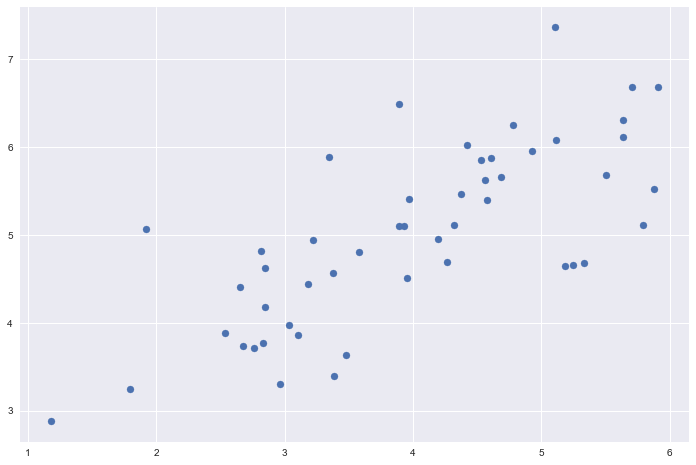

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:, 0], X[:, 1])

We can describe this data as having:

1. A <b>larger</b> degree of vertical variantion; and

    
2. A <b>smaller</b> degree of horiztonal variation.

### Step (3) - Define the PCA Algorithm

The algorithm for PCA is fairly simple.  After ensuring that the data is normalized, the output is simply the singular value decomposition of the covariance matrix of the original data.

In [54]:
def pca(X):
    
    # Normalize the features by subtracting the mean value of each 
    # feature from the dataset and scaling each dimension so they are
    # in the ame range
    X = (X - X.mean()) / X.std()
    
    # Compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    # Performs SVD using in-built SVD function
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

### Step (4) - Run PCA and ID principal components ($U$)

In [56]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([ 1.43584536,  0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

### Step (5) - Project Data to Lower-dimensional Space

Now that we have the principal components (matrix U), we can use these to project the original data into a lower-dimensional space.  For this task we'll implement a function that computes the projection and selects only the top K components, effectively reducing the number of dimensions.

#### (a) Define Projection Function

In [57]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

#### (b) Run Projection

In [58]:
Z = project_data(X, U, 1)
Z

matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

### Step (6) - Recover Original Data

We can also attempt to recover the original data by reversing the steps we took to project it.

#### (a) Define Recovery Function

We can also increase the number of dimensions back to the data's original dimensionality using this equation:

\begin{align}
x^{(1)}_{approx} = U_{reduce} \cdot z^{(1)}
\end{align}

However, note we can only return to <b>approximations</b> of our originla data.

In [59]:
def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

#### (b) Run Recovery Function

In [60]:
X_recovered = recover_data(Z, U, 1)
X_recovered

matrix([[ 3.76152442,  2.89550838],
        [ 5.67283275,  4.36677606],
        [ 3.80014373,  2.92523637],
        [ 3.53223661,  2.71900952],
        [ 3.80569251,  2.92950765],
        [ 5.57926356,  4.29474931],
        [ 3.93851354,  3.03174929],
        [ 6.94105849,  5.3430181 ],
        [ 4.93142811,  3.79606507],
        [ 5.58255993,  4.29728676],
        [ 5.48117436,  4.21924319],
        [ 5.38482148,  4.14507365],
        [ 5.02696267,  3.8696047 ],
        [ 5.54606249,  4.26919213],
        [ 3.60199795,  2.77270971],
        [ 6.58954104,  5.07243054],
        [ 5.681006  ,  4.37306758],
        [ 4.02614513,  3.09920545],
        [ 6.76785875,  5.20969415],
        [ 5.50019161,  4.2338821 ],
        [ 6.81311151,  5.24452836],
        [ 4.56923815,  3.51726213],
        [ 6.49947125,  5.00309752],
        [ 4.94381398,  3.80559934],
        [ 3.47034372,  2.67136624],
        [ 4.41334883,  3.39726321],
        [ 5.97375815,  4.59841938],
        [ 6.10672889,  4.700

#### (c) Plot Recovered Data

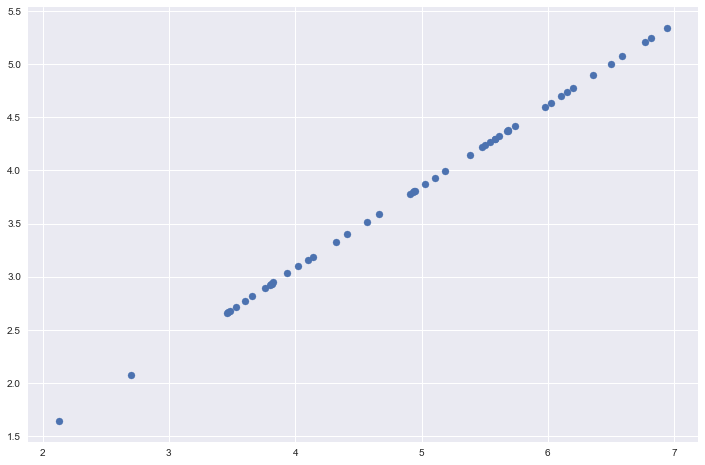

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter([X_recovered[:, 0]], [X_recovered[:, 1]])

Notice that the projection axis for the first principal component was basically a diagonal line through the data set.  

When we reduced the data to one dimension, we lost the variations around that diagonal line, so in our reproduction everything falls along that diagonal.

## (B) PCA with a Complex Dataset

Our last task in this exercise is to apply PCA to images of faces.  By using the same dimension reduction techniques we can capture the "essence" of the images using much less data than the original images.

### Step (1) - Load the Data

In [64]:
faces = loadmat('ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

The dataset:

1. Contains $X$ of face images, each 32 x 32 in grayscale.  


2. Each row of $X$ corresponds to one face image, a row vector of length 1024.

### Step (2) - Plot a Face

The exercise code includes a function that will render the first 100 faces in the data set in a grid.  

Rather than try to re-produce that here, you can look in the exercise text for an example of what they look like.  

We can at least render one image fairly easily though.

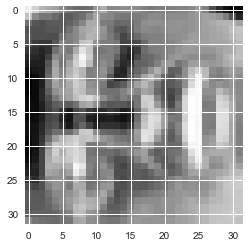

In [105]:
face = np.reshape(X[3,:], (32, 32))
plt.imshow(face)

Or even plot several faces if we really wish to do so:

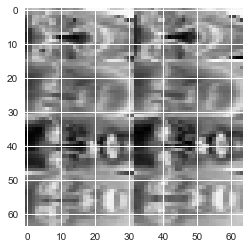

In [104]:
faces = np.reshape(X[0:4,:], (64, 64))
plt.imshow(faces)

Yikes, that looks awful.  These are only 32 x 32 grayscale images though (it's also rendering sideways, but we can ignore that for now).  Anyway's let's proceed.  

### Step (3) - Run PCA and ID the top 100 principal components.

In [107]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

### Step (4) - Recover the Original Structure and Re-render

Now we can attempt to recover the original structure and render it again.

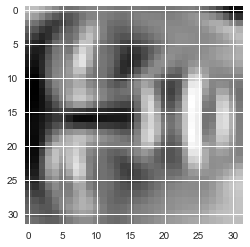

In [108]:
X_recovered = recover_data(Z, U, 100)
face = np.reshape(X_recovered[3,:], (32, 32))
plt.imshow(face)

Observe that we lost some detail, though not as much as you might expect for a 10x reduction in the number of dimensions.

That concludes exercise 7.  In the final exercise we'll implement algorithms for anomaly detection and build a recommendation system using collaborative filtering.